# Assignment 8
# Muhammad Abdullah


In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA #Principal Component Analysis
from sklearn.manifold import TSNE #T-Distributed Stochastic Neighbor Embedding
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
import numpy as np
import plotly as py
import plotly.graph_objs as go


In [3]:
df = pd.read_csv('baskin_robbins_icecream.csv')

1. Cleaning the data

In [4]:
df = df.drop(['Flavour', 'Category'], axis=1)

2. Scaling the data

In [5]:
scaler = MinMaxScaler()

df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

print(df_scaled.head())

   Calories  Total Fat (g)  Trans Fat (g)  Carbohydrates (g)  Sugars (g)  \
0  0.346154       0.133333            0.4               0.28    0.500000   
1  0.346154       0.150000            0.4               0.24    0.375000   
2  0.384615       0.150000            0.6               0.32    0.458333   
3  0.192308       0.066667            0.2               0.16    0.500000   
4  0.230769       0.033333            0.2               0.52    0.666667   

   Protein (g)  
0        0.250  
1        0.375  
2        0.375  
3        0.375  
4        0.250  


We have scaled the data and the values are fairly normalized by now, we are all set to cluster them.

3. Generate WSS (Knee Plot) to find optimal number of clusters. You can also plot Silhouette Coefficient plot to support your answer. 

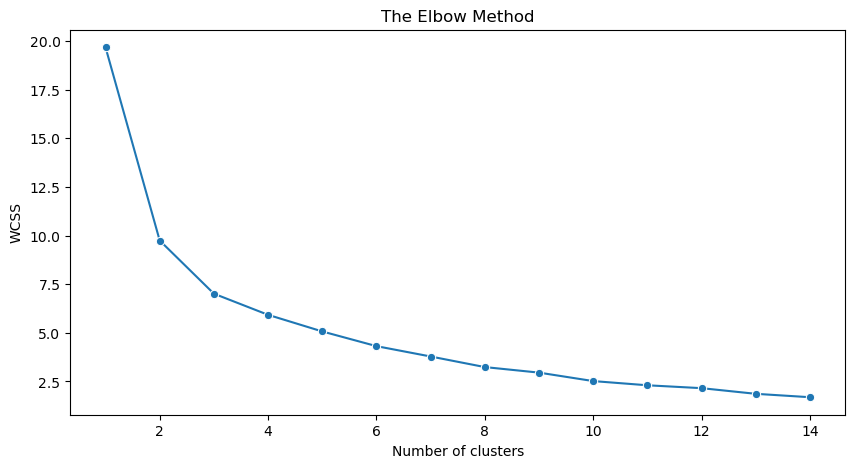

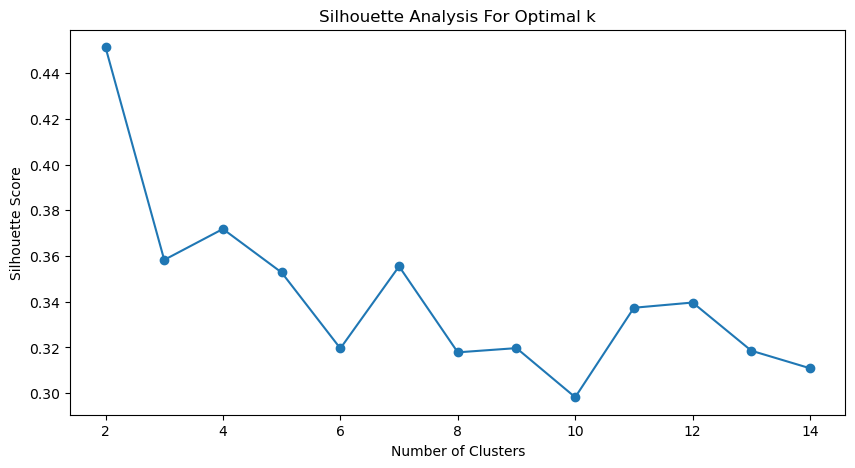

In [6]:
import warnings
warnings.filterwarnings('ignore')

wcss = []
for i in range(1, 15):
    kmeans = KMeans(n_clusters = i, max_iter = 300, n_init=10, random_state = 99)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
sns.lineplot(x=range(1, 15), y=wcss, marker='o')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


silhouette_scores = []
for n_clusters in range(2, 15):
    kmeans = KMeans(n_clusters=n_clusters, max_iter=300, random_state=99)
    cluster_labels = kmeans.fit_predict(df_scaled)
    silhouette_avg = silhouette_score(df_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(10, 5))
plt.plot(range(2, 15), silhouette_scores, marker='o')
plt.title('Silhouette Analysis For Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

In the elbow method, we can observe the 'knee' at around 3, all values below it decrease gradually. The silhouette analysis confirms that the optimal number of clusters is 3, the first local minima is found there too.

4. Perform K-Means clustering again with optimal number of clusters

In [21]:
optimal_clusters = 3
kmeans = KMeans(n_clusters=optimal_clusters, max_iter=300, random_state=99)
df_scaled['Cluster'] = kmeans.fit_predict(df_scaled)

print(df_scaled.head(15))

    Calories  Total Fat (g)  Trans Fat (g)  Carbohydrates (g)  Sugars (g)  \
0   0.346154       0.133333            0.4               0.28    0.500000   
1   0.346154       0.150000            0.4               0.24    0.375000   
2   0.384615       0.150000            0.6               0.32    0.458333   
3   0.192308       0.066667            0.2               0.16    0.500000   
4   0.230769       0.033333            0.2               0.52    0.666667   
5   0.307692       0.133333            0.6               0.20    0.416667   
6   0.192308       0.083333            0.2               0.32    0.000000   
7   0.384615       0.133333            0.4               0.32    0.541667   
8   0.500000       0.133333            0.4               1.00    0.125000   
9   0.576923       0.183333            0.8               0.52    0.625000   
10  0.461538       0.183333            0.4               0.36    0.541667   
11  0.615385       0.216667            0.8               0.48    0.583333   

Now that we have performed K-Means clustering using the optimal number of clusters, we can observe that the features are neatly clustered in 3 clusters from clusters 0-2.

5. Visualize the clustering results.

I perform a comprehensive visualization routine, using both PCA and SNE techniques.

t-SNE (t-distributed Stochastic Neighbor Embedding) is an unsupervised non-linear dimensionality reduction technique for data exploration and visualizing high-dimensional data. Non-linear dimensionality reduction means that the algorithm allows us to separate data that cannot be separated by a straight line. This strategy shows us the 3 distincts clusters without allowing any nonlinearity to affect the visualization.

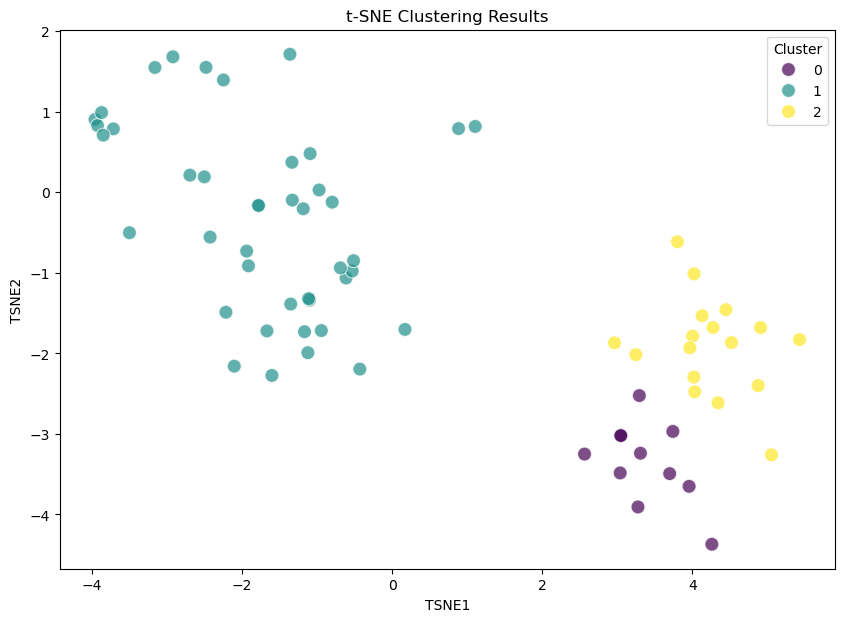

In [22]:
tsne = TSNE(n_components=2, random_state=99)
tsne_components = tsne.fit_transform(df_scaled.drop('Cluster', axis=1))

tsne_df = pd.DataFrame(data=tsne_components, columns=['TSNE1', 'TSNE2'])
tsne_df['Cluster'] = df_scaled['Cluster']

plt.figure(figsize=(10, 7))
sns.scatterplot(data=tsne_df, x='TSNE1', y='TSNE2', hue='Cluster', palette='viridis', s=100, alpha=0.7)
plt.title('t-SNE Clustering Results')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.legend(title='Cluster')
plt.show()

Then we also plot using PCA, again observing 3 distinct clusters but this time we mark centroids at the mean position of each cluster.

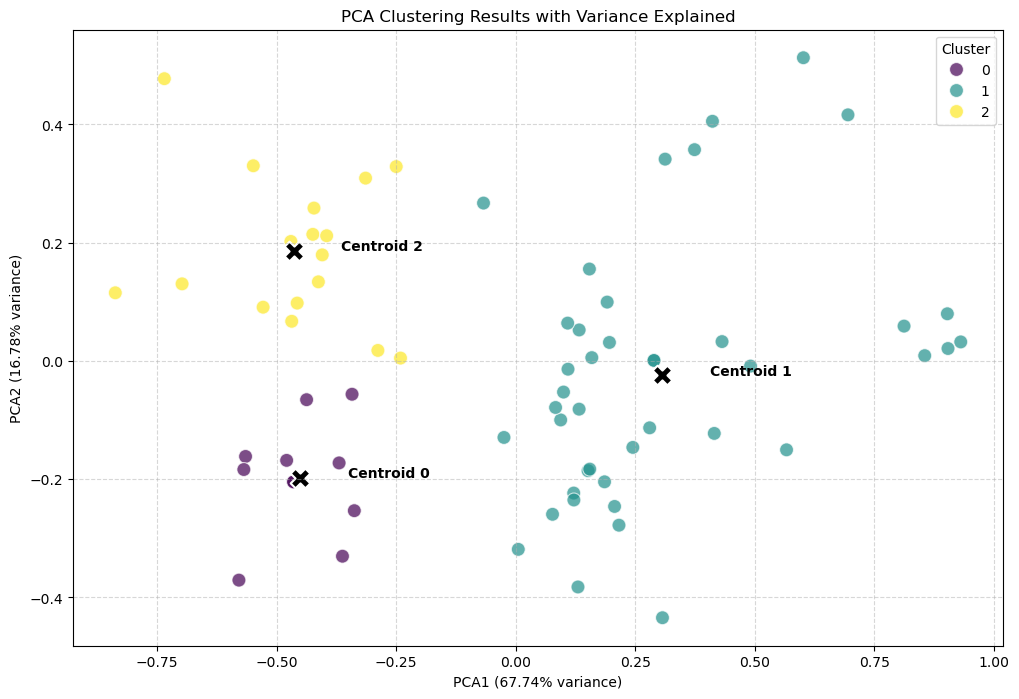

In [23]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(df_scaled.drop(columns=['Cluster']))

explained_var_ratio = pca.explained_variance_ratio_ * 100

pca_df = pd.DataFrame(data=pca_components, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = df_scaled['Cluster'].values

centroids = pca_df.groupby('Cluster')[['PCA1', 'PCA2']].mean()

plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Cluster', palette='viridis', s=100, alpha=0.7)

plt.xlabel(f'PCA1 ({explained_var_ratio[0]:.2f}% variance)')
plt.ylabel(f'PCA2 ({explained_var_ratio[1]:.2f}% variance)')
plt.title('PCA Clustering Results with Variance Explained')

for idx, centroid in centroids.iterrows():
    plt.scatter(centroid['PCA1'], centroid['PCA2'], s=200, c='black', marker='X', edgecolor='white', linewidth=1.5)
    plt.text(centroid['PCA1'] + 0.1, centroid['PCA2'], f'Centroid {int(idx)}', color='black', weight='bold')

plt.legend(title='Cluster')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

We also visualize using PCA components with dominant feature labels, this allows us to see the feature that dominates each cluster, this is something I elaborate on later when we draw insights into the clusters.

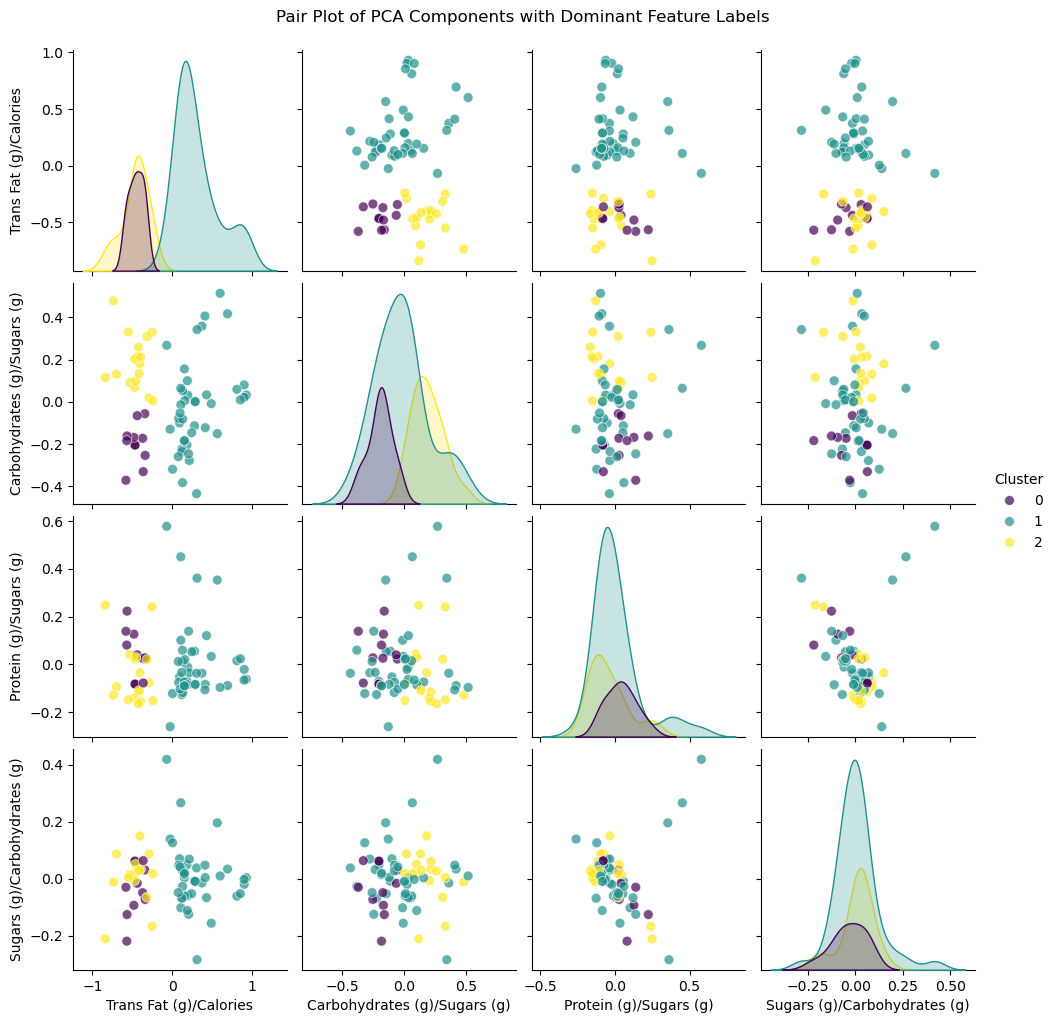

In [24]:
pca = PCA(n_components=4)
pca_components = pca.fit_transform(df_scaled.drop(columns=['Cluster']))

loadings = pd.DataFrame(pca.components_.T, index=df_scaled.drop(columns=['Cluster']).columns, columns=[f'PCA{i+1}' for i in range(4)])
dominant_features = {}
for i in range(4):
    dominant_features[f'PCA{i+1}'] = loadings.iloc[:, i].abs().sort_values(ascending=False).index[:2].tolist()

pca_df = pd.DataFrame(pca_components, columns=[f"{'/'.join(dominant_features[f'PCA{i+1}'])}" for i in range(4)])
pca_df['Cluster'] = df_scaled['Cluster'].values

sns.pairplot(pca_df, hue='Cluster', palette='viridis', plot_kws={'alpha': 0.7, 's': 50})
plt.suptitle('Pair Plot of PCA Components with Dominant Feature Labels', y=1.02)
plt.show()

Here I perform a PCA with 6 max components, assign labels to each PCA component, get two dominant features for each component and join them for labelling. I finally convert the PCA componetns into a df and show the correlation using a heatmap.

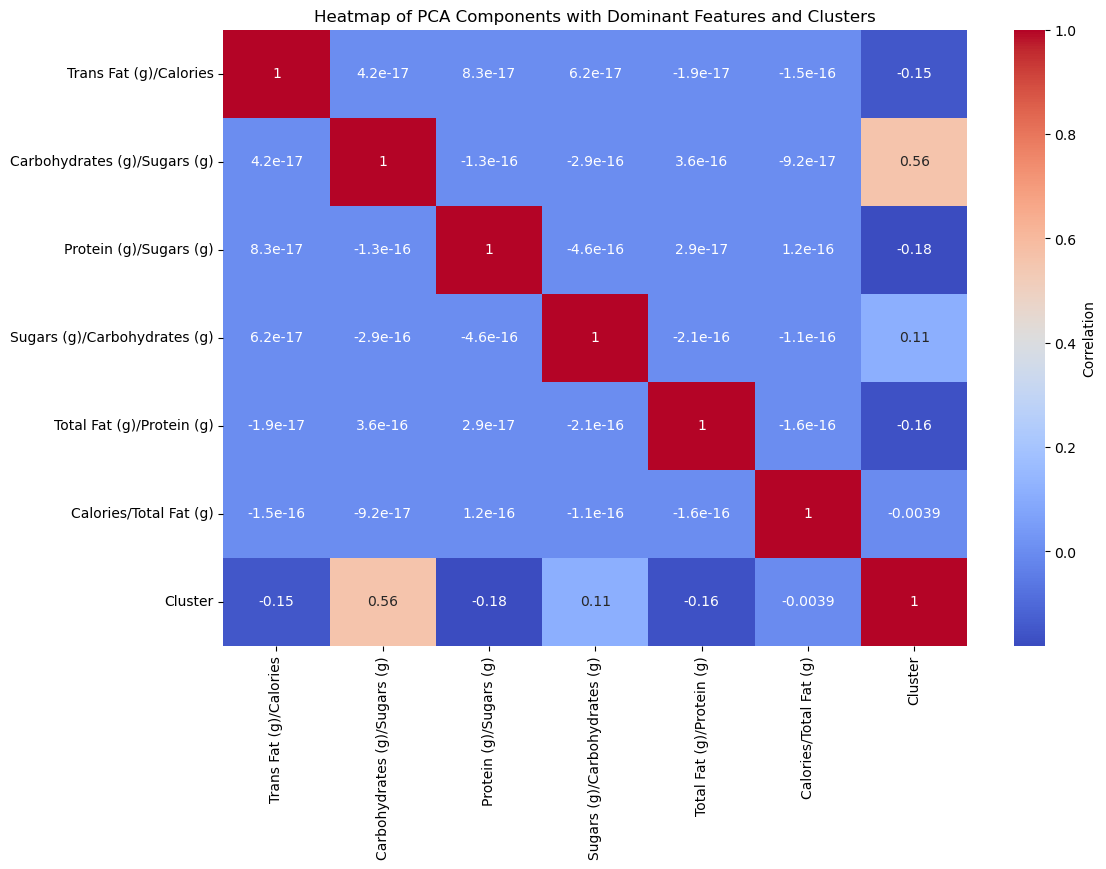

In [ ]:
pca = PCA(n_components=6)
pca_components = pca.fit_transform(df_scaled.drop(columns=['Cluster']))

loadings = pd.DataFrame(pca.components_.T, index=df_scaled.drop(columns=['Cluster']).columns, columns=[f'PCA{i+1}' for i in range(6)])
dominant_feature_labels = []
for i in range(6):
    top_features = loadings.iloc[:, i].abs().sort_values(ascending=False).index[:2].tolist()
    dominant_feature_labels.append(f"{'/'.join(top_features)}")

pca_df = pd.DataFrame(data=pca_components, columns=dominant_feature_labels)
pca_df['Cluster'] = df_scaled['Cluster'].values

plt.figure(figsize=(12, 8))
sns.heatmap(pca_df.corr(), annot=True, cmap='coolwarm', cbar_kws={'label': 'Correlation'})
plt.title('Heatmap of PCA Components with Dominant Features and Clusters')
plt.show()

6. Use cluster labels to create cluster specific data frames from original dataset.

In [12]:
df['Cluster'] = df_scaled['Cluster']

cluster_dfs = {}
for cluster in df['Cluster'].unique():
    cluster_dfs[cluster] = df[df['Cluster'] == cluster]

for cluster, cluster_df in cluster_dfs.items():
    print(f"Cluster {cluster} DataFrame:")
    print(cluster_df.head(), "\n") 

Cluster 1 DataFrame:
   Calories  Total Fat (g)  Trans Fat (g)  Carbohydrates (g)  Sugars (g)  \
0       160            8.0            0.2                 20          16   
1       160            9.0            0.2                 19          13   
2       170            9.0            0.3                 21          15   
3       120            4.0            0.1                 17          16   
4       130            2.0            0.1                 26          20   

   Protein (g)  Cluster  
0          2.0        1  
1          3.0        1  
2          3.0        1  
3          3.0        1  
4          2.0        1   

Cluster 2 DataFrame:
    Calories  Total Fat (g)  Trans Fat (g)  Carbohydrates (g)  Sugars (g)  \
9        220           11.0            0.4                 26          19   
13       280           15.0            0.5                 31          23   
15       280           17.0            0.4                 29          20   
20       240           12.0        

I created a new column in the original dataframes to store cluster labels, then created a dictionary to store the cluster dataframe. The above output also shows the first few rows of the cluster dataframe.

7. Generate at least 3 insights from your clustering results to show unique and interesting features for each cluster. Discuss your findings.

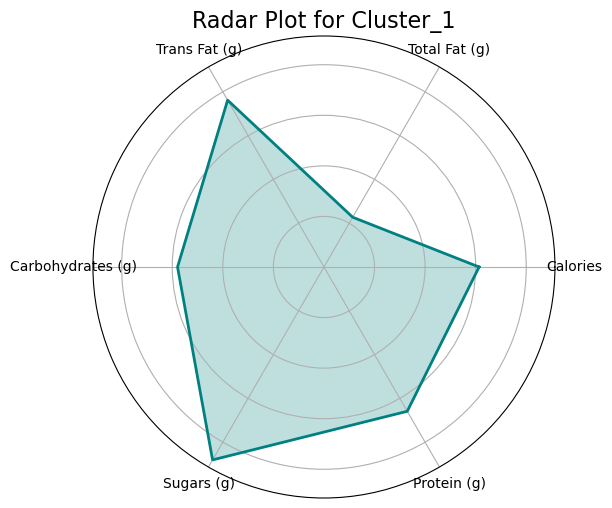

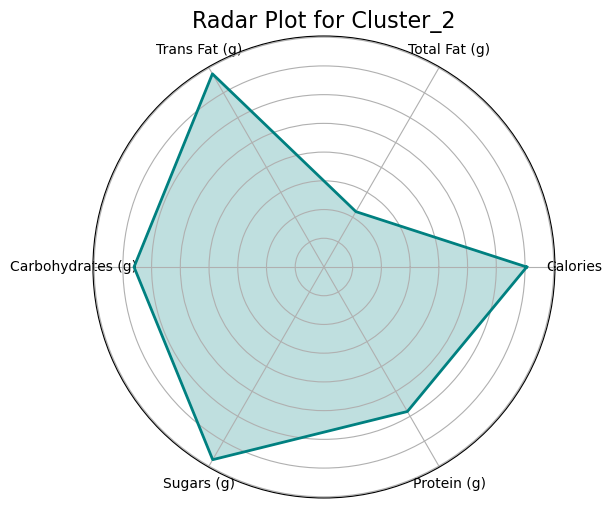

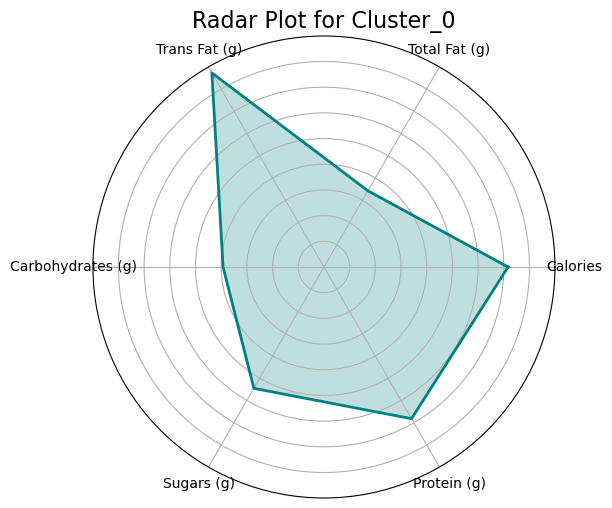

In [13]:

clusters = df_scaled['Cluster'].unique()
cluster_dfs = {f'Cluster_{int(c)}': df_scaled[df_scaled['Cluster'] == c].drop(columns=['Cluster']) for c in clusters}

cluster_stats = {cluster: data.describe().loc[['mean', 'std']] for cluster, data in cluster_dfs.items()}

def radar_plot(cluster_name, data):
    means = data.mean()
    categories = means.index
    num_vars = len(categories)

    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    means = np.concatenate((means, [means[0]]))
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.fill(angles, means, color='teal', alpha=0.25)
    ax.plot(angles, means, color='teal', linewidth=2)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    ax.set_yticklabels([])

    plt.title(f'Radar Plot for {cluster_name}', size=16)
    plt.show()

for cluster_name, data in cluster_dfs.items():
    radar_plot(cluster_name, data)

Insight 1:

Cluster 0 is characterized by an alarmingly high level of trans fat, significantly overshadowing the relatively low total fat content. Despite the lower carbohydrate and sugar values, the high trans fat content likely contributes to a moderate calorie count. The protein content in this cluster appears to be moderate, and the carb content appears to be low.

Cluster 1 exhibits a relatively balanced nutritional profile across various components. While trans fat content is not negligible, it is not as pronounced as in other clusters. Total fat intake appears to be moderate, suggesting a reasonable balance. Carbohydrate levels are also moderate, contributing to the overall energy content. Protein content is notably moderate, indicating a potential source of satiety and muscle building. The calorie count in this cluster likely stems from a combination of moderate fat and high sugar intake, with protein contributing to a moderate level.

Cluster 2 is characterized by a distinctive profile. The most prominent feature is the high trans fat content, which stands out significantly. Total fat content, while not negligible, is relatively lower compared to the trans fat. Carbohydrates appear to be moderate, suggesting a balanced intake in this area, while sugar content appears to be excessively high. Protein content is also moderate, contributing to the overall nutritional profile. The high trans fat content, however, is likely the primary driver of the calorie count in this cluster.

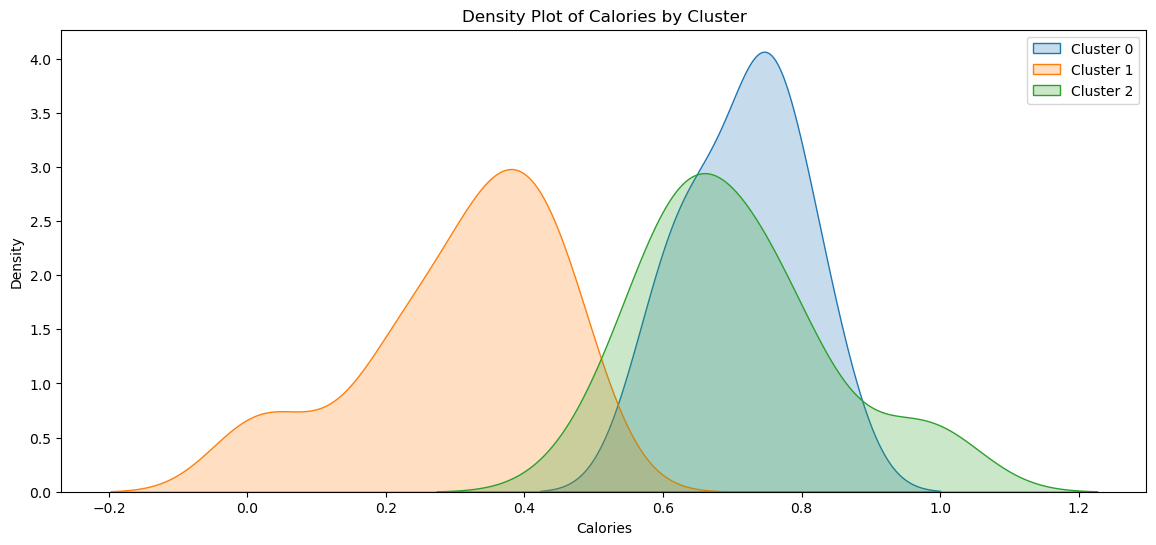

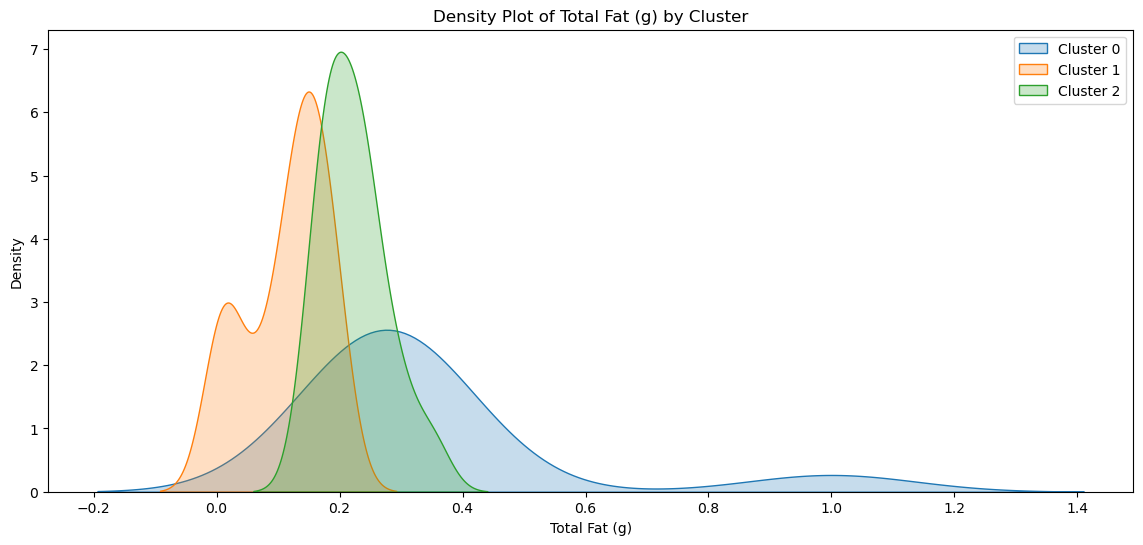

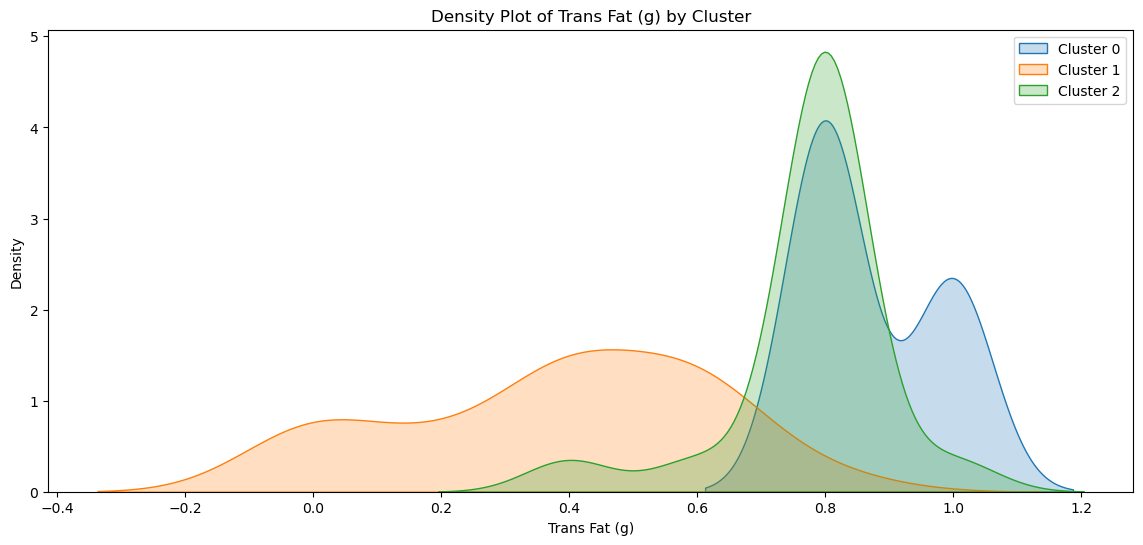

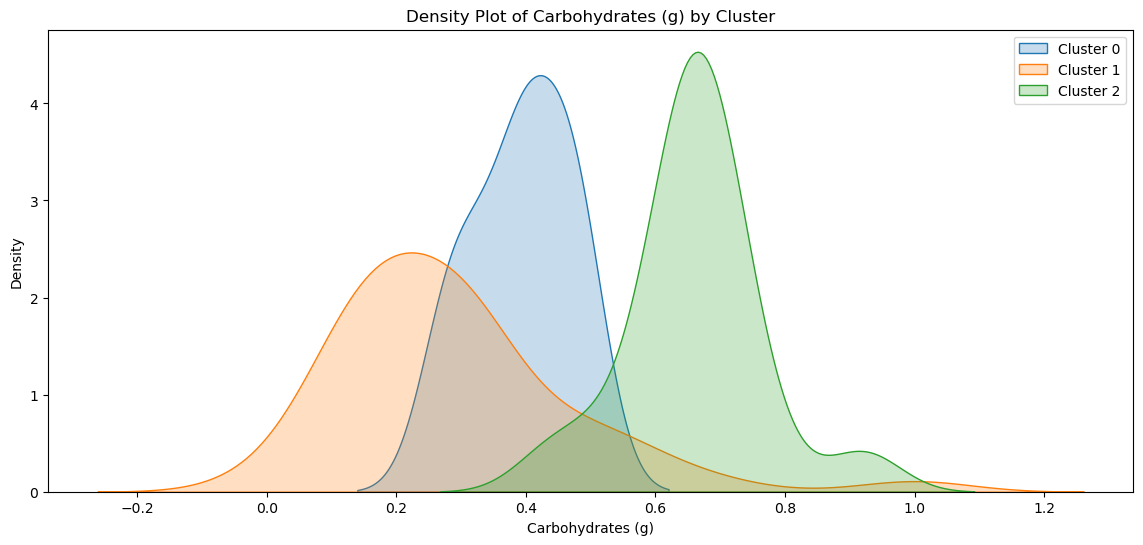

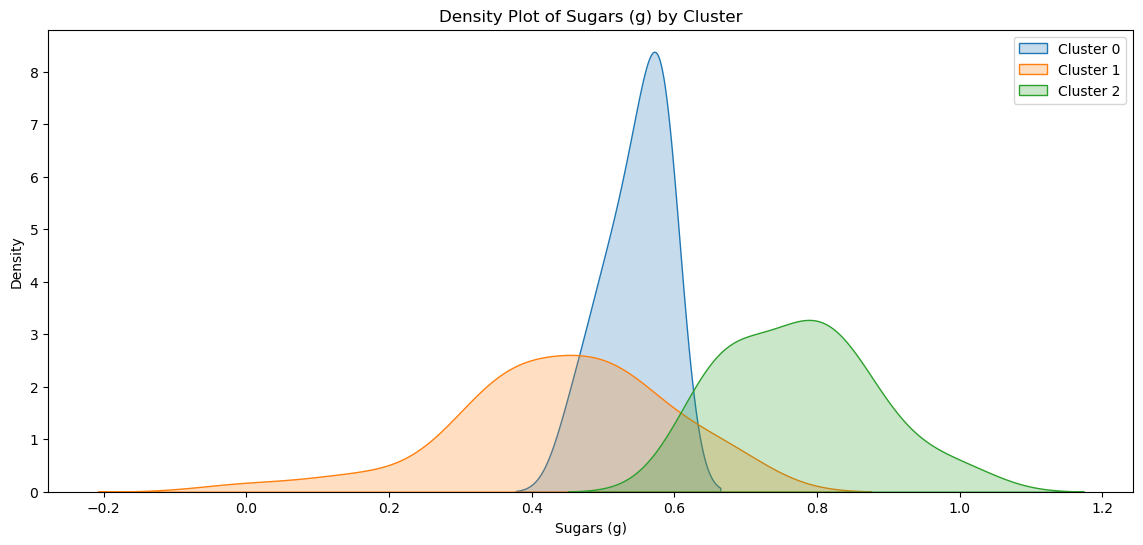

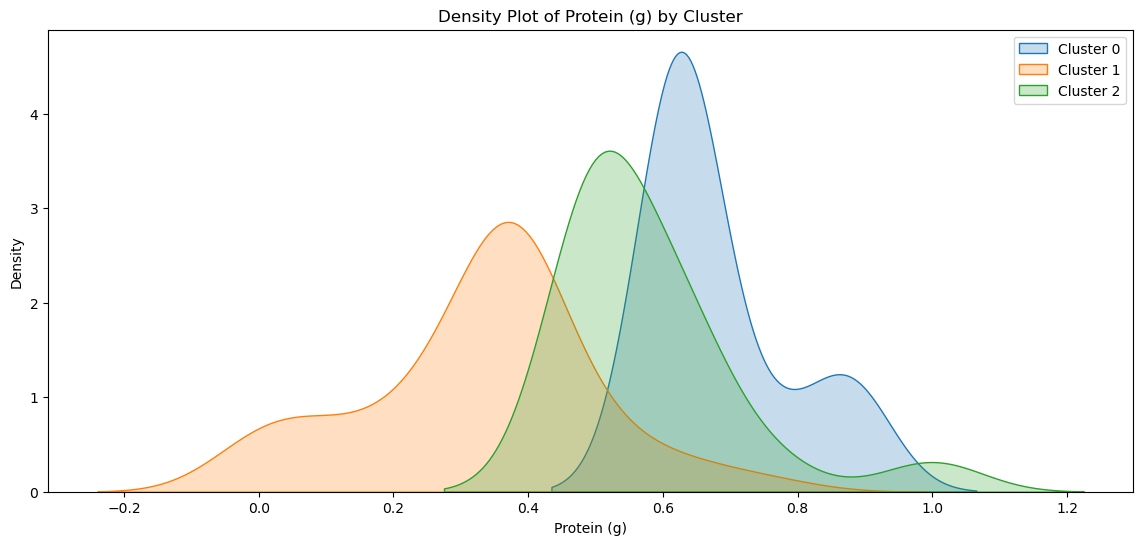

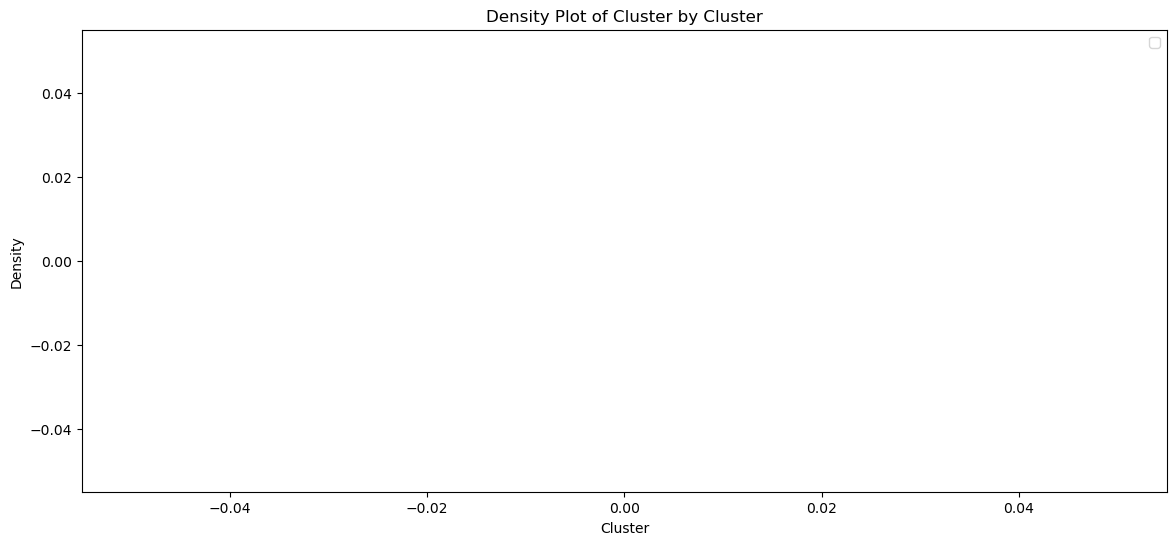

In [18]:
optimal_k = 3 
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=99)
kmeans.fit(df_scaled)
df['cluster'] = kmeans.labels_

for col in df_scaled.columns:
    plt.figure(figsize=(14, 6))
    for cluster in range(optimal_k):
        sns.kdeplot(df_scaled[col][df['cluster'] == cluster], label=f'Cluster {cluster}', fill=True)
    plt.title(f'Density Plot of {col} by Cluster')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.legend()
    plt.show()

In the density plot of Calories by Cluster we can see the density spread of calories per cluster. The spread is almost the same for cluster 1 and 2, with almost the same densities mirrored about 0.5 calories, but cluster 0, while least spread, achieves the highest density at about 0.75 calories.

In the density plot of total fat by cluster we can see that the total fat has the largest spread in cluster 0, while the spread is similar in clusters 1 and 2, with the cluster 2 achieving higher density at 0.25g Total Fat.

For Trans Fat by cluster we can see that cluster 1 has the largest spread. Cluster 2 has the highest density at 0.8g Trans Fat.

For Carbs by cluster we can see that cluster 2 has the highest density at 0.7g Carbs but the spread is largest for cluster 1.

For Sugars by cluster we can see an alarmingly high density of 8.5 and 0.55g sugar. This is almost 3 times as much dense as cluster 2 or cluster 1.

For Protein by cluster we can see that cluster 0 has the highest density at 0.65g Protein.



Now I will create the histogram plots of each feature by cluster.

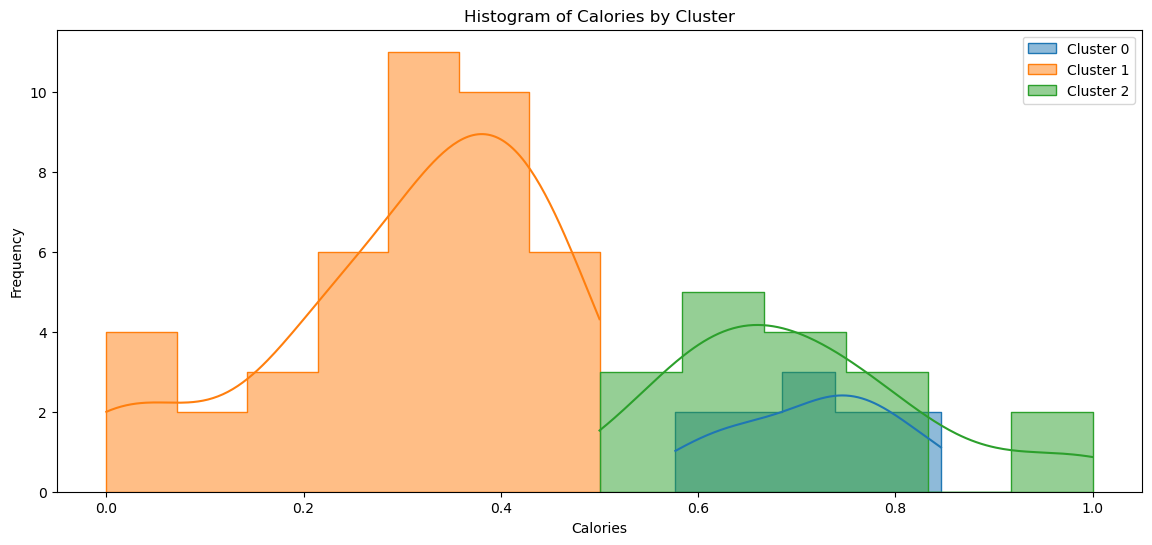

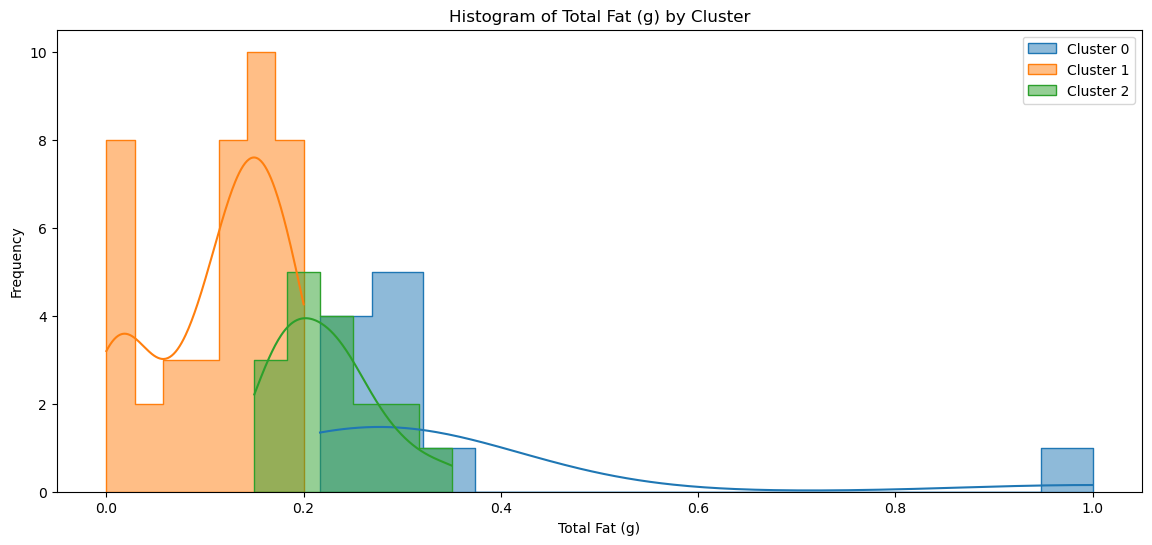

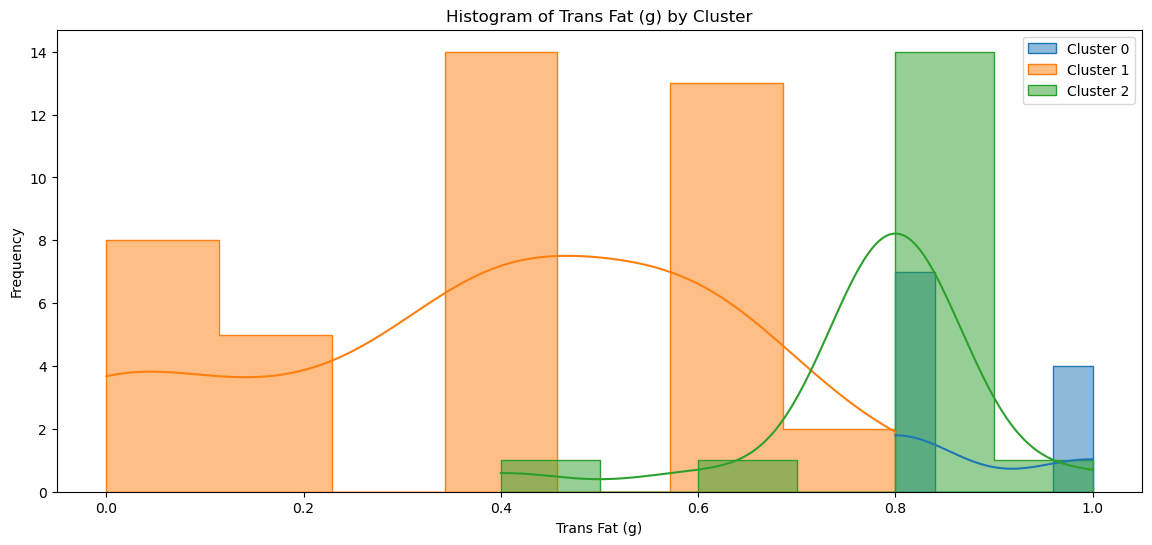

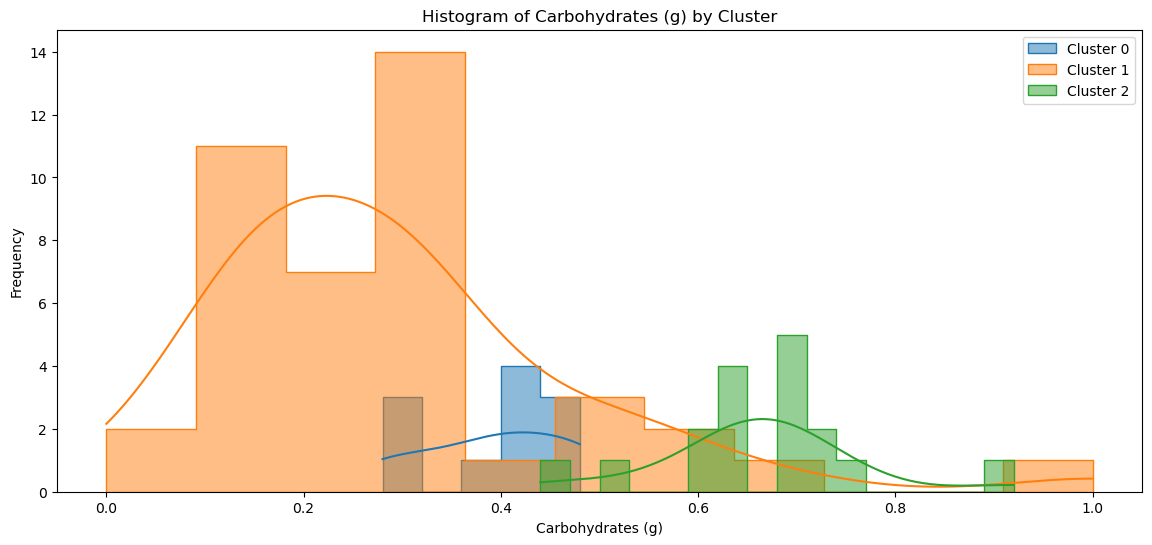

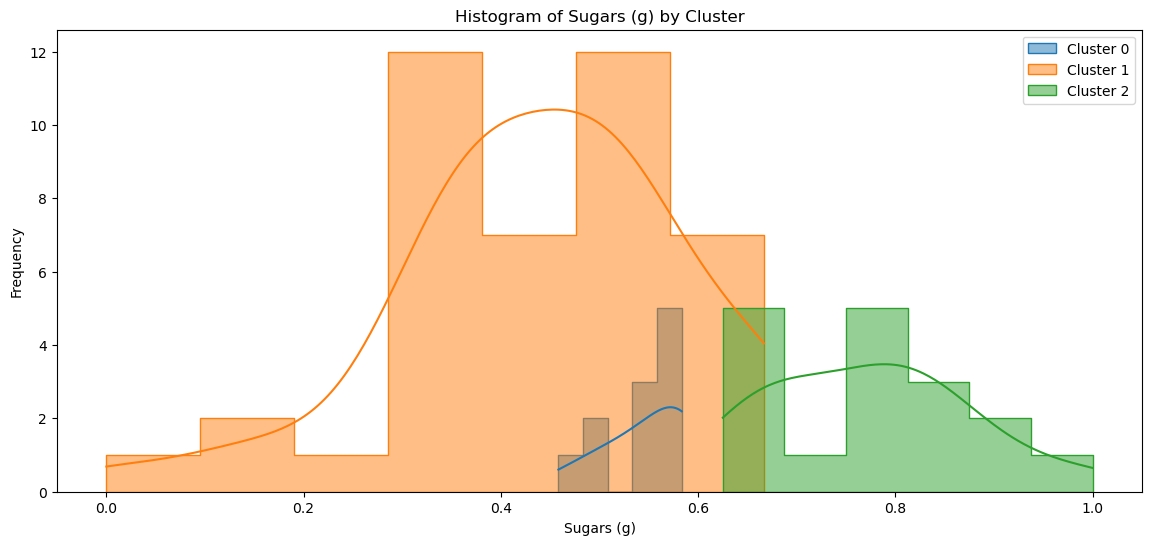

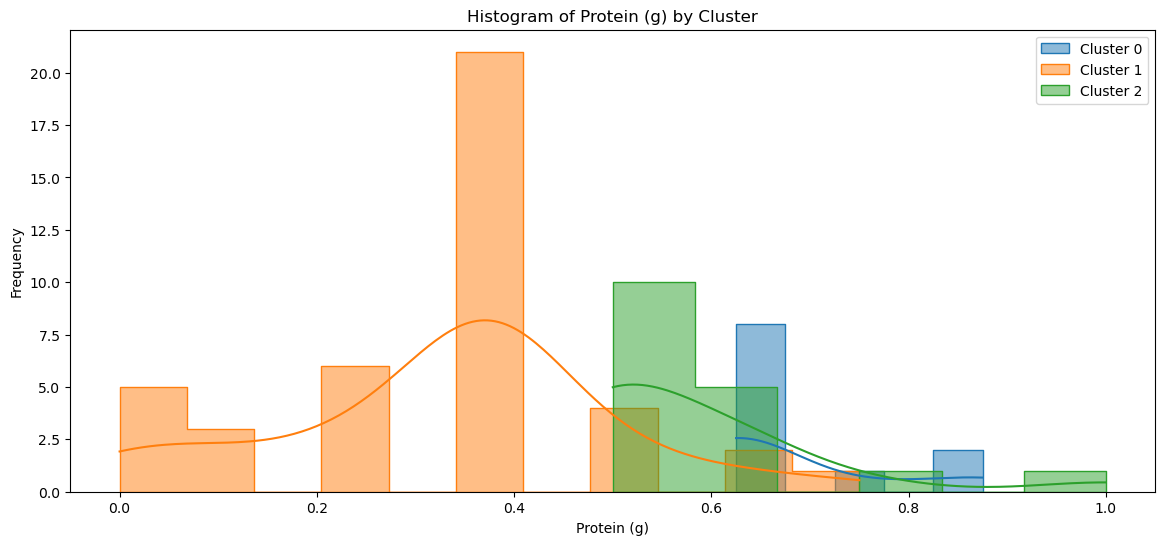

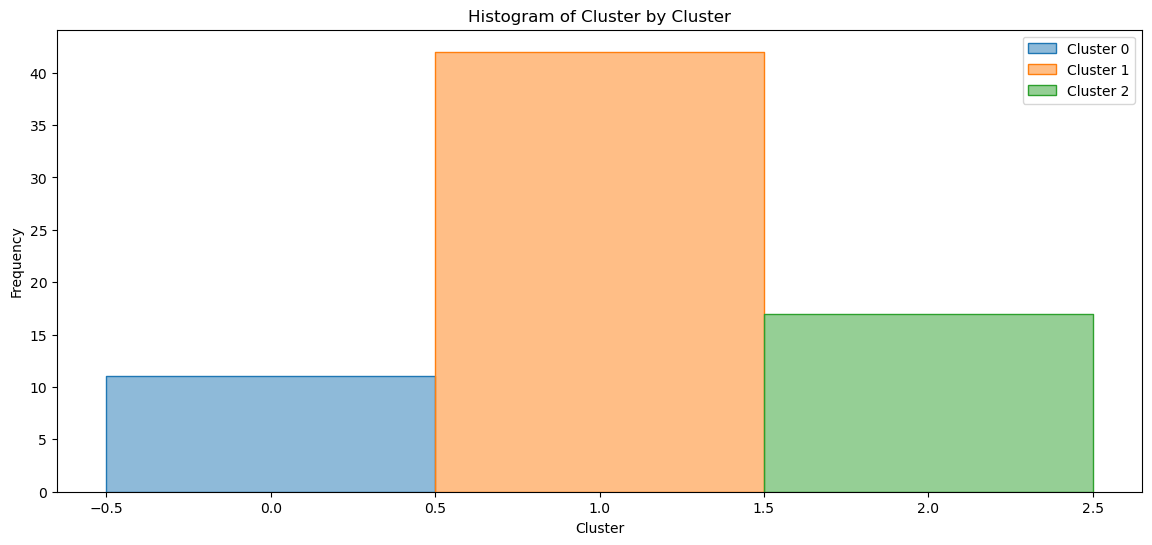

In [19]:
optimal_k = 3 
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=99)
kmeans.fit(df_scaled)
df['cluster'] = kmeans.labels_

for col in df_scaled.columns:

    plt.figure(figsize=(14, 6))
    for cluster in range(optimal_k):
        sns.histplot(df_scaled[col][df['cluster'] == cluster], label=f'Cluster {cluster}', kde=True, element="step")
    plt.title(f'Histogram of {col} by Cluster')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

In the histograms, we can observe the frequencies of each feature per cluster.

In Calories by cluster histograms we can see that the highest frequency of calories is in cluster 1. The least is in cluster 0.

In Total Fat by cluster histograms we can see that the highest frequency of Total Fat is in cluster 1.

In Trans Fat by cluster we see that the clusters 1 and 2 both have the highest frequency values. 

Carbohydrates dominate cluster 1, and are least present in cluster 0.

Sugars dominate cluster 1.

Proteins have their highest frequency in cluster 1.


8. Can you suggest a unique name for each cluster? For example if a cluster is showing 
high Sugar level, then you can call it a “SugarLovers” cluster.

Cluster 0: Fatty Indulgence because it has the largest spread in Total Fat.

Cluster 1: Carb Connoisseurs because it has the largest spread in Carbohydrates.

Cluster 2: Reserved Indulgence because it does not dominantly spread in any feature.

The rationale for all of these is given in the above density plots and histograms.